In [41]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
import sim
import time
import math
import threading
import matplotlib.image as mpimg
import networkx as nx


configs = {
  "grid-size": (50, 50),
  "map-x-limits": (-5, 5),
  "map-y-limits": (-5, 5),
  "runtime-limit": 240,
  "sensor-max-dist": 5,
  "noise-std": 0,
  "num-robos": 2
}

grid = np.ones(configs["grid-size"]) / 2

l_occ = np.log(0.65 / 0.35) #1.1
l_free = np.log(0.35 / 0.65) #0.1
l_0 = 0

In [42]:
class Robo:
    def __init__(self, nome):
        returnCode, handle = sim.simxGetObjectHandle(clientID, nome, sim.simx_opmode_oneshot_wait)     
        
        # Handle para as juntas das RODAS
        returnCode, l_wheel = sim.simxGetObjectHandle(clientID, nome + "_leftMotor", sim.simx_opmode_oneshot_wait)
        returnCode, r_wheel = sim.simxGetObjectHandle(clientID, nome + "_rightMotor", sim.simx_opmode_oneshot_wait)    
        
        # Cada robô lê o seu sensor.
        self.NOME_SENSOR = "hokuyo_range_data" + nome[-1]

        # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
        # Em loop até garantir que as leituras serão válidas
        returnCode = 1
        while returnCode != 0:
            returnCode, range_data = sim.simxGetStringSignal(clientID, self.NOME_SENSOR, sim.simx_opmode_streaming + 10)
            returnCode, self.floor = sim.simxGetObjectHandle(clientID, "ResizableFloor_5_25", sim.simx_opmode_oneshot_wait)

        self.scan_range = 180 * np.pi / 180
        self.step_size = 2 * np.pi / 1024
        
        # Encontra a posição do robô em relação ao mundo
        returnCode, self.pos = sim.simxGetObjectPosition(clientID, handle, -1, sim.simx_opmode_streaming)
        
        # Dados do Pioneer
        self.L = 0.381   # Metros
        self.r = 0.0975  # Metros
        self.id = handle
        self.roda_esq, self.roda_dir = l_wheel, r_wheel
        self.laser_data = []
        
        # Velocidade básica (linear, angular)
        self.v, self.w = 0, np.deg2rad(0)
        
    def leia_sensores(self):
        returnCode = 1
        while returnCode != 0:
          returnCode, string_range_data = sim.simxGetStringSignal(clientID, self.NOME_SENSOR, sim.simx_opmode_buffer)
          raw_range_data = sim.simxUnpackFloats(string_range_data)
          self.laser_data = format_laser_data(raw_range_data, self.scan_range, self.step_size)
        
        returnCode = 1
        while returnCode != 0:
            
          # Encontra a rotação relativa do chão em relação ao robô
          returnCode, floor_r = sim.simxGetObjectOrientation(clientID, self.floor, self.id, sim.simx_opmode_streaming)

          # Cria a matriz de transformação
          floor_m = create_matrix(self.pos, Rz(floor_r[2]))
        
        robot_grid_x, robot_grid_y = discretize_pos(self.pos[0], self.pos[1], configs)
        
        readings = []
        for (ang, dist) in self.laser_data:
          if dist < configs["sensor-max-dist"]:
            dist += np.random.normal(0, configs["noise-std"])
            ang += np.random.normal(0, configs["noise-std"])

            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            real_pos = floor_m @ np.array([x, y, 0, 1])

            grid_x, grid_y = discretize_pos(real_pos[0], real_pos[1], configs)
            rr, cc = line(robot_grid_x, robot_grid_y, grid_x, grid_y)

            line_pos = [(x, y) for x, y in zip(rr, cc)]
            readings.append((line_pos[1:], dist))
        
        return readings
    
    def move(self):
        ''' Lógica de movimentação. Caso a frente esteja vazia, ande para a frente,
        caso contrário vire para um lado vazio '''
        
        frente = int(len(self.laser_data) / 2)
        lado_direito = int(len(self.laser_data) * 1 / 4)
        lado_esquerdo = int(len(self.laser_data) * 3 / 4)

        if self.laser_data[frente, 1] > 2:
          self.v = 0.6
          self.w = 0
        elif self.laser_data[lado_direito, 1] > 2 or self.laser_data[lado_direito, 1] > self.laser_data[lado_esquerdo, 1]:
          self.v = 0
          self.w = np.deg2rad(-30)
        elif self.laser_data[lado_esquerdo, 1] > 2 or self.laser_data[lado_direito, 1] < self.laser_data[lado_esquerdo, 1]:
          self.v = 0
          self.w = np.deg2rad(30)
    
        # Modelo Cinemático
        wl = self.v / self.r - (self.w * self.L) / (2 * self.r)
        wr = self.v / self.r + (self.w * self.L) / (2 * self.r)
        
        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, self.roda_esq, wl, sim.simx_opmode_streaming + 5)
        sim.simxSetJointTargetVelocity(clientID, self.roda_dir, wr, sim.simx_opmode_streaming + 5)        
        
        # Encontra a posição do robô em relação ao mundo
        returnCode, self.pos = sim.simxGetObjectPosition(clientID, self.id, -1, sim.simx_opmode_streaming)
    
    def pare(self):
      sim.simxSetJointTargetVelocity(clientID, self.roda_dir, 0, sim.simx_opmode_oneshot_wait)
      sim.simxSetJointTargetVelocity(clientID, self.roda_esq, 0, sim.simx_opmode_oneshot_wait)        

In [43]:
def Rz(theta):
  return np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta),  np.cos(theta), 0],
                   [0            ,  0            , 1]])

def create_matrix(translation, rotation, scale=1):
  return np.array([[rotation[0][0], rotation[1][0], rotation[2][0], translation[0]],
                   [rotation[0][1], rotation[1][1], rotation[2][1], translation[1]],
                   [rotation[0][2], rotation[1][2], rotation[2][2], translation[2]],
                   [0             , 0             , 0             , scale]])

def format_laser_data(range_data, scan_range, step_size, max_sensor_range=5):
  laser_data = []
  range_data = np.asarray(range_data)
  pts = math.floor(scan_range / step_size)
  angle = -scan_range * 0.5
  for i in range(pts):
    dist = range_data[i]        
    if dist <= 0:
      dist = max_sensor_range
    laser_data.append([angle, dist])
    angle = angle + step_size
  return np.array(laser_data)

def discretize_pos(x, y, config):
  min_x, max_x = config["map-x-limits"]
  min_y, max_y = config["map-y-limits"]
  grid_size_x, grid_size_y = config["grid-size"]

  clipped_x = np.clip(x, min_x, max_x)
  clipped_y = np.clip(y, min_y, max_y)
  new_x = int(np.floor((clipped_x - min_x) / (max_x - min_x) * grid_size_x))
  new_y = int(np.floor((clipped_y - min_y) / (max_y - min_y) * grid_size_y))
  return min(new_x, grid_size_x - 1), min(int(new_y), grid_size_y - 1)

In [44]:
def update_map(readings, r=0.1):
  global grid
  for reading in readings:
    grid_line = reading[0]
    dist = reading[1]
    p_line = np.zeros(len(grid_line))
    for i in range(len(grid_line)):
      line_dist = (dist / len(grid_line)) * (i + 1)
      if line_dist < (dist - r / 2):
        p_line[i] = l_free #0.1
      elif line_dist >= (dist - r / 2) and line_dist <= (dist + r / 2):
        p_line[i] = l_occ #1.1
      else:
        p_line[i] = 0.5

    for pos, val in zip(grid_line, p_line):
      grid[pos] = grid[pos] + val - l_0 #val

Program started
Connected to remote API server


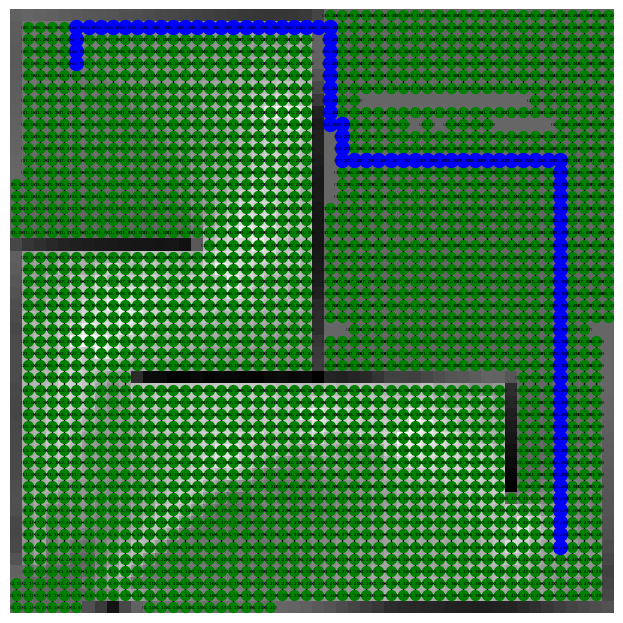

Program ended


In [45]:
print ("Program started")
sim.simxFinish(-1)
clientID = sim.simxStart("127.0.0.1", 19999, True, True, 5000, 5)

if clientID != -1:
  print ("Connected to remote API server")

  robos = [Robo("/robo" + str(i)) for i in range(configs["num-robos"])]
  
  t = 0
  startTime = time.time()
  lastTime = startTime
  iteration = -1

  while t < configs["runtime-limit"]:
    iteration += 1
    now = time.time()
    dt = now - lastTime
    
    for i in range(configs["num-robos"]):
        leituras = robos[i].leia_sensores() 
        update_map(leituras)
        robos[i].move()
                   
    t = t + dt  
    lastTime = now

  for i in range(configs["num-robos"]):
      robos[i].pare()
        
  # Criando vértices em todas as células
  G = nx.grid_2d_graph(50, 50) 

  # Removendo células que estão em células marcadas com obstáculos
  for r in range(50):
      for c in range(50):
          if grid[c][r] > .6:
              c = c*(-1) + 49
              G.remove_node((c,r))

  fig = plt.figure(figsize=(8,8), dpi=100)
  ax = fig.add_subplot(111, aspect='equal')

  # Grid 
  obj = ax.imshow(grid, cmap='Greys', extent=(0, 50, 0, 50))

  ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
  ax.set_xticks(np.arange(0, 50+1, 1))
  ax.set_yticks(np.arange(0, 50+1, 1))

  # Os vértices serão plotados no centro da célula  
  pos = {node:(node[1]*1+1/2 - .5 , 50-node[0]*1-1/2 - .5) for node in G.nodes()}
  nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)
    
  #(y, x)
  start_node = (45, 5)
  end_node = (5, 45)

  # Caminho
  path = nx.shortest_path(G, source=start_node, target=end_node)
  nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')
    
  plt.imshow(grid, cmap="Greys")
  plt.show()
        
  sim.simxStopSimulation(clientID, sim.simx_opmode_blocking)         
  sim.simxFinish(clientID)

else:
  print ("Failed connecting to remote API server")
    
print ("Program ended")